In [1]:
import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.special import j0, jv, spherical_jn
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import math

In [2]:
c = 3e5 # km/s, speed of light
H0 = 67.66 # km/s/Mpc, Hubble constant

chi_0 = c/H0 # Mpc

Omega_Lambda0 = 0.7
Omega_m0 = 0.3

def chi_z_func(z, y):
    chi = y[0]

    dchi_dz = chi_0 / np.sqrt(Omega_Lambda0+Omega_m0*(1+z)**3)
    return [dchi_dz]
def a_chi(chi, chi_sol, z_min, z_max):
    def func_tem(chi, chi_sol):
        return chi_sol-chi
    z = brentq(func_tem, z_min, z_max, args=(chi_sol))
    return 1/(1+z)

z_rng = [0, 2]
chi_ini = [0]
sol_chi = solve_ivp(chi_z_func, z_rng, chi_ini, dense_output=True, atol = 1e-9, rtol = 1e-7)

In [3]:
def a_chi(chi_target, chi_sol, z_min, z_max):
    def func_tem(z, ct):
        current_chi = chi_sol(z)[0]  # 解返回数组，取第一个元素
        return current_chi - ct
    z = brentq(func_tem, z_min, z_max, args=(chi_target,))
    return 1 / (1 + z)

In [4]:
chi_list_test = np.linspace(0, 2000, 10000)
a_chi(chi_list_test[-1], sol_chi.sol, 0, 3)

0.6608312493030117

In [5]:
sol_chi.sol(0.3)[0]

1236.560476701354

In [6]:
h = 0.67
Theta_CMB = 1

def alpha_c_func(Omega_b, Omega_c):
    Omega_0 = Omega_b+Omega_c
    a1 = (46.9*Omega_0*h**2)**(0.67)*(1+(32.1*Omega_0*h**2)**(-0.532))
    a2 = (12*Omega_0*h**2)**(0.424)*(1+(45*Omega_0*h**2)**(-0.582))

    alphac = a1**(-Omega_b/Omega_0)*a2**(-(Omega_b/Omega_0)**3)
    return alphac

def beta_c_func(Omega_b, Omega_c):
    Omega_0 = Omega_b+Omega_c
    b1 = 0.944*(1+(458*Omega_0*h)**(-0.708))**(-1)
    b2 = (0.395*Omega_0*h**2)**(-0.0266)
    betac = (1+b1*((Omega_c/Omega_0)**b2-1))**(-1)

    return betac

def k_eq(Omega_b, Omega_c):
    Omega_0 = Omega_b+Omega_c
    return 7.46e-2*Omega_0*h**2*Theta_CMB**(-2) # Unit: Mpc^{-1}

def q_func(k, keq):
    return k/(13.41*keq)

#def C_func(Omega_b, Omega_c, k):
#    keq = k_eq(Omega_b, Omega_c, Theta_CMB)
#    C_value = 14.2/alpha_c(Omega_b, Omega_c)+386/(1+69.9*q_func(k, keq)**(1.08))
#    return C_value

def C_func(alpha_c, q):
    return 14.2/alpha_c+386/(1+69.9*q**1.08)

#def T_tilde_0(Omega_b, Omega_c, k):
#    keq = k_eq(Omega_b, Omega_c, Theta_CMB)
#    T_tilde_0_value = np.log(math.e+1.8*beta_c(Omega_b, Omega_c)*q_func(k, keq))\
#        /(np.log(math.e+1.8*beta_c(Omega_b, Omega_c)*q_func(k, keq))+C_func(Omega_b, Omega_c, Theta_CMB, k)*q_func(k, keq)**2)
#    return T_tilde_0_value

def T_tilde_0(k, alpha_c, beta_c, keq):
    q = q_func(k, keq)
    return np.log(math.e+1.8*beta_c*q)/(np.log(math.e+1.8*beta_c*q)+C_func(alpha_c, q)*q**2)

def R_func(Omega_b, z):
    return 31.5*Omega_b*h**2*Theta_CMB**(-4)*(z/1000)**(-1)

def s_func(Omega_b, Omega_c):
    Omega_0 = Omega_b+Omega_c
    u1 = 0.313*(Omega_0*h**2)**(-0.419)*(1+0.607*(Omega_0*h**2)**0.674)
    u2 = 0.238*(Omega_0*h**2)**0.223
    z_eq = 2.50e4*Omega_0*h**2*Theta_CMB**(-4)
    z_d = 1291*(Omega_0*h**2)**0.251/(1+0.659*(Omega_0*h**2)**0.828)*(1+u1*(Omega_0*h**2)**u2)
    R_eq = R_func(Omega_b, z_eq)
    R_d = R_func(Omega_b, z_d)
    s_value = 2/(3*k_eq(Omega_b, Omega_c))*np.sqrt(6/R_eq)*np.log((np.sqrt(1+R_d)+np.sqrt(R_eq+R_d))/(1+np.sqrt(R_eq)))

    return s_value

def T_c(Omega_b, Omega_c, k):
    alpha_c = alpha_c_func(Omega_b, Omega_c)
    beta_c = beta_c_func(Omega_b, Omega_c)
    keq = k_eq(Omega_b, Omega_c)
    s = s_func(Omega_b, Omega_c)
    f = 1/(1+(k*s/5.4)**4)
    return f*T_tilde_0(k, 1, beta_c, keq)+(1-f)*T_tilde_0(k, alpha_c, beta_c, keq)

def G_func(y):
    return y*(-6*np.sqrt(1+y)+(2+3*y)*np.log((np.sqrt(1+y)+1)/(np.sqrt(1+y)-1)))

def T_b(Omega_b, Omega_c, k):
    Omega_0 = Omega_b+Omega_c
    keq = k_eq(Omega_b, Omega_c)
    s = s_func(Omega_b, Omega_c)
    u1 = 0.313*(Omega_0*h**2)**(-0.419)*(1+0.607*(Omega_0*h**2)**0.674)
    u2 = 0.238*(Omega_0*h**2)**0.223
    z_eq = 2.50e4*Omega_0*h**2*Theta_CMB**(-4)
    z_d = 1291*(Omega_0*h**2)**0.251/(1+0.659*(Omega_0*h**2)**0.828)*(1+u1*(Omega_0*h**2)**u2)
    R_eq = R_func(Omega_b, z_eq)
    R_d = R_func(Omega_b, z_d)
    alpha_b = 2.07*keq*s*(1+R_d)**(-3/4)*G_func((1+z_eq)/(1+z_d))
    beta_b = 0.5+Omega_b/Omega_0+(3-2*Omega_b/Omega_0)*np.sqrt(1+(17.2*Omega_0*h**2)**2)
    k_silk = 1.6*(Omega_b*h**2)**0.52*(Omega_0*h**2)**0.73*(1+(10.4*Omega_0*h**2)**(-0.95)) # Mpc^{-1}
    beta_node = 8.41*(Omega_0*h**2)**0.435

    part1 = T_tilde_0(k, 1, 1, keq)/(1+(k*s/5.2)**2)+alpha_b/(1+(beta_b/(k*s))**3)*np.exp(-(k/k_silk)**(1.4))
    part2 = np.sinc(k*s/(1+(beta_node/(k*s))**3)**(1/3)/np.pi)

    return part1*part2

def T_func(Omega_b, Omega_c, k):
    Omega_0 = Omega_b+Omega_c

    return (Omega_b/Omega_0)*T_b(Omega_b, Omega_c, k)+(Omega_c/Omega_0)*T_c(Omega_b, Omega_c, k)

In [7]:
Omega_b = 0.02242/h**2
Omega_c = 0.11933/h**2
sigma8 = 0.81
n = 0.96
R = 8 / h # Mpc

In [8]:
def W(k):
    kR = k * R
    return 3 * spherical_jn(1, kR) / (kR)

def integrand(k):
    return k**(n + 2) * T_func(Omega_b, Omega_c, k)**2 * W(k)**2

k_min = 1e-4  # h/Mpc
k_max = 10.0   # h/Mpc
integral, error = quad(integrand, k_min, k_max)

# 计算 A
A = sigma8**2 / integral
print(f"A = {A:.1f} h^-(3+n) Mpc^(3+n)")
print(integral)

A = 683645.2 h^-(3+n) Mpc^(3+n)
9.597083829009549e-07


In [9]:
def Power_spectrum(k):
    return 2*np.pi**2*A*k**n*T_func(Omega_b, Omega_c, k)**2

def integral_chi_part(chi, chi1, chi2):
    return ((chi1-chi)*(chi2-chi))/(chi1*chi2*a_chi(chi, sol_chi.sol, 0, 3)**2)

def integral_l_part_xi_plus(l, chi, theta_arcmin):
    theta_rad = theta_arcmin * (np.pi/10800)
    part1 = Power_spectrum(l/chi)
    part2 = (l/np.pi*2)*j0(l*theta_rad)

    return part1 * part2

def integral_l_part_xi_minus(l, chi, theta_arcmin):
    theta_rad = theta_arcmin * (np.pi/10800)
    part1 = Power_spectrum(l/chi)
    part2 = (l/np.pi*2)*jv(4, l*theta_rad)

    return part1 * part2

def chi_integrand_xi_plus(chi, chi1, chi2, theta_arcmin):
    weight = integral_chi_part(chi, chi1, chi2)
    l_min, l_max = 0, 1e4
    inner_result = quad(integral_l_part_xi_plus, l_min, l_max, args = (chi, theta_arcmin), limit=1000)[0]

    return weight * inner_result

def chi_integrand_xi_minus(chi, chi1, chi2, theta_arcmin):
    weight = integral_chi_part(chi, chi1, chi2)
    l_min, l_max = 0, 1e4
    inner_result = quad(integral_l_part_xi_minus, l_min, l_max, args = (chi, theta_arcmin), limit=1000)[0]

    return weight * inner_result

def compute_xi_plus_integral(chi1, chi2, theta_arcmin):
    chi_max = min(chi1, chi2)
    result = quad(chi_integrand_xi_plus, 0, chi_max, args = (chi1, chi2, theta_arcmin), limit=1000)[0]

    return result

def compute_xi_minus_integral(chi1, chi2, theta_arcmin):
    chi_max = min(chi1, chi2)
    result = quad(chi_integrand_xi_minus, 0, chi_max, args = (chi1, chi2, theta_arcmin), limit=1000)[0]

    return result

In [10]:
chi1a, chi2a = 1236.56, 433.23
chi1b, chi2b = 1236.56, 845.55
chi1c, chi2c = 1236.56, 1236.56
chi1d, chi2d = 1236.56, 1606.32
chi1e, chi2e = 1236.56, 1955.30

theta_arcmin_list = np.linspace(0, 100, 10)

xi_plusa = []
xi_plusb = []
xi_plusc = []
xi_plusd = []
xi_pluse = []

for i in range(len(theta_arcmin_list)):
    xi_plusa.append(compute_xi_plus_integral(chi1a, chi2a, theta_arcmin_list[i]))
    xi_plusb.append(compute_xi_plus_integral(chi1b, chi2b, theta_arcmin_list[i]))
    xi_plusc.append(compute_xi_plus_integral(chi1c, chi2c, theta_arcmin_list[i]))
    xi_plusd.append(compute_xi_plus_integral(chi1d, chi2d, theta_arcmin_list[i]))
    xi_pluse.append(compute_xi_plus_integral(chi1e, chi2e, theta_arcmin_list[i]))

In [11]:
xi_minusa = []
xi_minusb = []
xi_minusc = []
xi_minusd = []
xi_minuse = []

for i in range(len(theta_arcmin_list)):
    xi_minusa.append(compute_xi_minus_integral(chi1a, chi2a, theta_arcmin_list[i]))
    xi_minusb.append(compute_xi_minus_integral(chi1b, chi2b, theta_arcmin_list[i]))
    xi_minusc.append(compute_xi_minus_integral(chi1c, chi2c, theta_arcmin_list[i]))
    xi_minusd.append(compute_xi_minus_integral(chi1d, chi2d, theta_arcmin_list[i]))
    xi_minuse.append(compute_xi_minus_integral(chi1e, chi2e, theta_arcmin_list[i]))

In [12]:
xi_plusa = np.array(xi_plusa)
xi_plusb = np.array(xi_plusb)
xi_plusc = np.array(xi_plusc)
xi_plusd = np.array(xi_plusd)
xi_pluse = np.array(xi_pluse)

xi_minusa = np.array(xi_minusa)
xi_minusb = np.array(xi_minusb)
xi_minusc = np.array(xi_minusc)
xi_minusd = np.array(xi_minusd)
xi_minuse = np.array(xi_minuse)

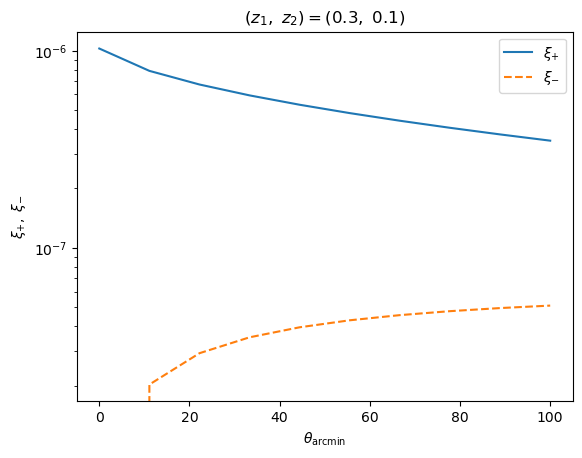

In [ ]:
factor = ((3/2)*chi_0**(-2)*Omega_m0)**2
plt.plot(theta_arcmin_list, factor*xi_plusa, label = r'$\xi_{+}$')
plt.plot(theta_arcmin_list, factor*xi_minusa, label = r'$\xi_{-}$', linestyle = '--')
plt.xlabel(r'$\theta_{\rm arcmin}$')
plt.ylabel(r'$\xi_{+},\ \xi_{-}$')
plt.legend()
plt.yscale('log')
plt.title(r'$(z_{1},\ z_{2})=(0.3,\ 0.1)$')
#plt.savefig('/Users/zengyuhe/academic_doc/Classes/Cosmology/HW/HW9_Figures/0_3_0_1.pdf')
plt.show()

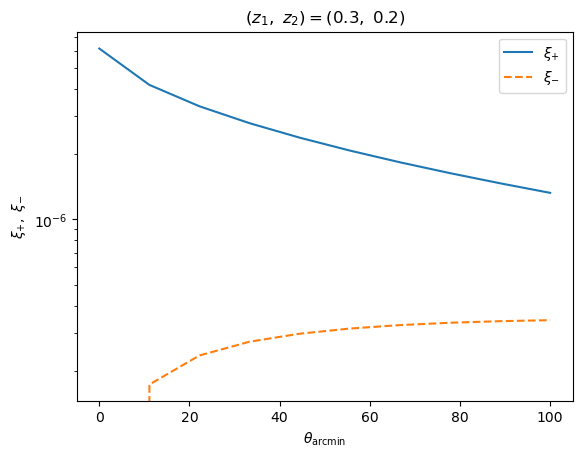

In [ ]:
plt.plot(theta_arcmin_list, factor*xi_plusb, label = r'$\xi_{+}$')
plt.plot(theta_arcmin_list, factor*xi_minusb, label = r'$\xi_{-}$', linestyle = '--')
plt.xlabel(r'$\theta_{\rm arcmin}$')
plt.ylabel(r'$\xi_{+},\ \xi_{-}$')
plt.legend()
plt.yscale('log')
plt.title(r'$(z_{1},\ z_{2})=(0.3,\ 0.2)$')
#plt.savefig('/Users/zengyuhe/academic_doc/Classes/Cosmology/HW/HW9_Figures/0_3_0_2.pdf')
plt.show()

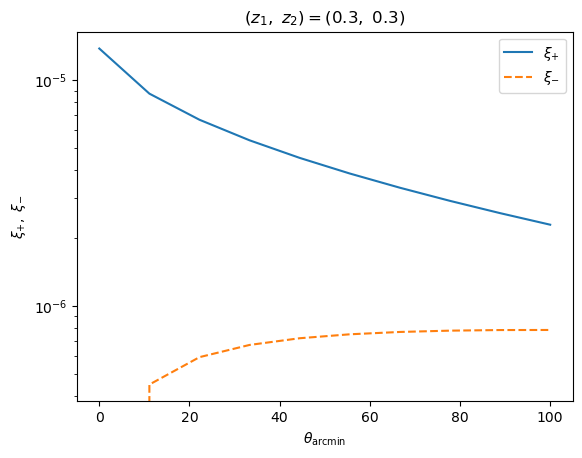

In [ ]:
plt.plot(theta_arcmin_list, factor*xi_plusc, label = r'$\xi_{+}$')
plt.plot(theta_arcmin_list, factor*xi_minusc, label = r'$\xi_{-}$', linestyle = '--')
plt.xlabel(r'$\theta_{\rm arcmin}$')
plt.ylabel(r'$\xi_{+},\ \xi_{-}$')
plt.legend()
plt.yscale('log')
plt.title(r'$(z_{1},\ z_{2})=(0.3,\ 0.3)$')
#plt.savefig('/Users/zengyuhe/academic_doc/Classes/Cosmology/HW/HW9_Figures/0_3_0_3.pdf')
plt.show()

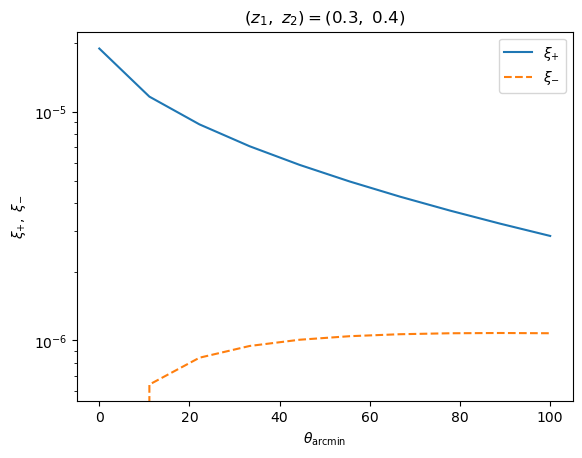

In [ ]:
plt.plot(theta_arcmin_list, factor*xi_plusd, label = r'$\xi_{+}$')
plt.plot(theta_arcmin_list, factor*xi_minusd, label = r'$\xi_{-}$', linestyle = '--')
plt.xlabel(r'$\theta_{\rm arcmin}$')
plt.ylabel(r'$\xi_{+},\ \xi_{-}$')
plt.legend()
plt.yscale('log')
plt.title(r'$(z_{1},\ z_{2})=(0.3,\ 0.4)$')
#plt.savefig('/Users/zengyuhe/academic_doc/Classes/Cosmology/HW/HW9_Figures/0_3_0_4.pdf')
plt.show()

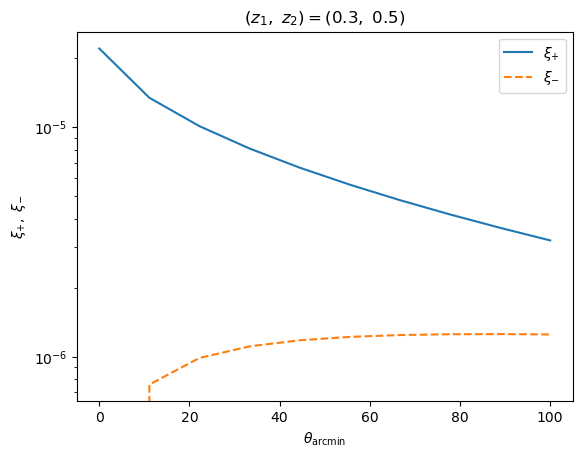

In [ ]:
plt.plot(theta_arcmin_list, factor*xi_pluse, label = r'$\xi_{+}$')
plt.plot(theta_arcmin_list, factor*xi_minuse, label = r'$\xi_{-}$', linestyle = '--')
plt.xlabel(r'$\theta_{\rm arcmin}$')
plt.ylabel(r'$\xi_{+},\ \xi_{-}$')
plt.legend()
plt.yscale('log')
plt.title(r'$(z_{1},\ z_{2})=(0.3,\ 0.5)$')
#plt.savefig('/Users/zengyuhe/academic_doc/Classes/Cosmology/HW/HW9_Figures/0_3_0_5.pdf')
plt.show()